In [46]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor



## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

In [3]:
if not os.path.isfile('housing.csv'):
    !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 03:40:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.06s   

2022-10-17 03:40:52 (24.1 MB/s) - ‘housing.csv’ saved [1423529/1423529]



> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [4]:
raw = pd.read_csv('housing.csv')
columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'
]

df = raw[columns]
df = df.fillna(value=0)
df['median_house_value'] = np.log(df.median_house_value)

In [5]:
full_train, test = train_test_split(df, train_size=0.8, random_state=1)
train, val = train_test_split(full_train, train_size = 0.75, random_state=1)

In [23]:
dfs = [train, val, test]

train_y, val_y, test_y = [dat.median_house_value for dat in dfs] 

df_x = df.drop('median_house_value', axis=1)

DV = DictVectorizer(sparse=False)
DV.fit(df_x.to_dict(orient='records'))

train_x, val_x, test_x = [DV.transform(dat.to_dict(orient='records')) for dat in dfs]

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

In [25]:
MAX_DEPTH = 1
dt = DecisionTreeRegressor(max_depth=MAX_DEPTH)
dt.fit(train_x, train_y)

print(export_text(dt, feature_names=DV.get_feature_names_out().tolist()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

In [30]:
N_ESTIMATORS = 10
RANDOM_STATE = 1
N_JOBS = 1

rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
rf.fit(train_x, train_y)

rf_val_preds = rf.predict(val_x)
rmse = mean_squared_error(val_y, rf_val_preds, squared=False)

print(f'RMSE: {rmse}')

RMSE: 0.2453508692239376


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

In [45]:
def train_rf_and_get_rmse(n_estimators, max_depth=None):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)
    rf.fit(train_x, train_y, n_jobs=-1)

    rf_val_preds = rf.predict(val_x)
    rmse = mean_squared_error(val_y, rf_val_preds, squared=False)
    return rmse

res = []
for n_estimators in range(10, 210, 10):
    rmse = train_rf_and_get_rmse(n_estimators)
    res.append({
        'n_estimators': n_estimators,
        'rmse': rmse
    })

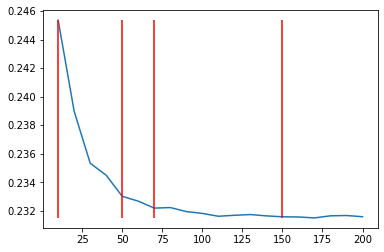

In [47]:
df_rmse = pd.DataFrame.from_records(res)
plt.plot(df_rmse.n_estimators, df_rmse.rmse)
plt.vlines([10, 50, 70, 150], ymin=df_rmse.rmse.min(), ymax=df_rmse.rmse.max(), colors='red')

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [49]:
MAX_DEPTHS = [10, 15, 20, 25]
N_ESTIMATORS = range(10, 201, 10)
RANDOM_STATE = 1

grid_res = []
for md in MAX_DEPTHS:
    for ne in N_ESTIMATORS:
        rmse = train_rf_and_get_rmse(n_estimators=ne, max_depth=md)
        grid_res.append({
            'n_estimators': ne,
            'max_depth': md,
            'rmse': rmse
        })

In [57]:
gred_res_df = pd.DataFrame.from_records(grid_res)
grid_res_pivot = gred_res_df.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])

In [114]:
grid_res_pivot.agg(np.mean) \
    .reset_index(level=0, drop=True) \
    .reset_index() \
    .rename(columns={0: 'rmse'}) \
    .sort_values('rmse', ascending=True)

,max_depth,rmse
3,25,0.233416
2,20,0.233448
1,15,0.235039
0,10,0.250041


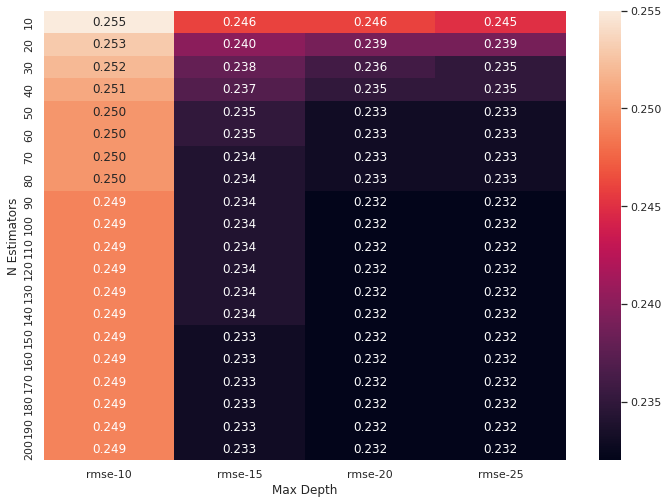

In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
hm = sns.heatmap(grid_res_pivot.round(3), annot=True, fmt='.3f')
hm.set(xlabel='Max Depth', ylabel='N Estimators')
plt.show()

# Question 5

We can exfrom_recordsture importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [ ]:
MD = 20
NE = 10
RS = 1
NJ = -1

rf = RandomForestRegressor(n_estimators=NE, max_depth=MD, random_state=RS, num_jobs=NJ)
rm.forest.feature_importances_

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

## Submit the results

* Submit your results here: https://forms.gle/3yMSuQ4BeNuZFHTU8
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is 17 October (Monday), 23:00 CEST.

After that, the form will be closed.

